In [1]:
#importing packages
import pandas as pd
import numpy as np

In [2]:
Dtrain = pd.read_csv("../TrainingSet (IR - 7).csv")
Dtest = pd.read_csv("../TestingSet (IR - 7).csv")

In [3]:
print(Dtrain.shape)
print(Dtest.shape)

(193792, 4)
(48448, 4)


In [4]:
Dtrain["Bearing"].value_counts()

Normal                 96896
Inner Race (0.007")    96896
Name: Bearing, dtype: int64

In [5]:
Dtrain["Bearing"].value_counts(normalize=True)*100

Normal                 50.0
Inner Race (0.007")    50.0
Name: Bearing, dtype: float64

In [6]:
Dtest.columns

Index(['Bearing', 'Fault Diameter', 'DE', 'FE'], dtype='object')

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
labelencoder_train = LabelEncoder()
Dtrain["Bearing"] = labelencoder_train.fit_transform(Dtrain["Bearing"])
ct = ColumnTransformer([("Bearing", OneHotEncoder(), [0])],    remainder = 'passthrough')
Dtrain = ct.fit_transform(Dtrain)

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
labelencoder_train = LabelEncoder()
Dtest["Bearing"] = labelencoder_train.fit_transform(Dtest["Bearing"])
ct = ColumnTransformer([("Bearing", OneHotEncoder(), [0])],    remainder = 'passthrough')
Dtest = ct.fit_transform(Dtest)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(Dtrain))
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(Dtest))

In [10]:
X_train = X_train.values.reshape(-1, 1, 5)

X_test  = X_test.values.reshape(-1, 1, 5)

In [11]:
from keras.layers import Input, Dropout, Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential, load_model
from keras import regularizers

Using TensorFlow backend.


In [12]:
# Input layer:
model=Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
    Dropout(0.2),
    RepeatVector(X_train.shape[1]),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(X_train.shape[2]))
])

model.compile(loss='mse',optimizer='adam' )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 5)              165       
Total params: 13,349
Trainable params: 13,349
Non-trainable params: 0
__________________________________________________

In [13]:
# Train model for 100 epochs, batch size of 100: 
NUM_EPOCHS=100
BATCH_SIZE=1000

history=model.fit(X_train,X_train, 
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_data=(X_test, X_test),
                  shuffle=False)

Train on 193792 samples, validate on 48448 samples
Epoch 1/100
193792/193792 [==============================] - 8s 39us/step - loss: 0.1673 - val_loss: 0.1572
Epoch 2/100
193792/193792 [==============================] - 3s 16us/step - loss: 0.0522 - val_loss: 0.0100
Epoch 3/100
193792/193792 [==============================] - 3s 15us/step - loss: 0.0190 - val_loss: 0.0042
Epoch 4/100
193792/193792 [==============================] - 3s 16us/step - loss: 0.0156 - val_loss: 0.0038
Epoch 5/100
193792/193792 [==============================] - 3s 16us/step - loss: 0.0138 - val_loss: 0.0034
Epoch 6/100
193792/193792 [==============================] - 3s 15us/step - loss: 0.0122 - val_loss: 0.0033
Epoch 7/100
193792/193792 [==============================] - 2s 11us/step - loss: 0.0107 - val_loss: 0.0031
Epoch 8/100
193792/193792 [==============================] - 2s 10us/step - loss: 0.0096 - val_loss: 0.0030
Epoch 9/100
193792/193792 [==============================] - 2s 12us/step - loss: 0.0

Epoch 76/100
193792/193792 [==============================] - 4s 22us/step - loss: 0.0035 - val_loss: 0.0013
Epoch 77/100
193792/193792 [==============================] - 4s 22us/step - loss: 0.0035 - val_loss: 0.0012
Epoch 78/100
193792/193792 [==============================] - 4s 23us/step - loss: 0.0035 - val_loss: 0.0012
Epoch 79/100
193792/193792 [==============================] - 4s 22us/step - loss: 0.0035 - val_loss: 0.0013
Epoch 80/100
193792/193792 [==============================] - 5s 23us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 81/100
193792/193792 [==============================] - 4s 22us/step - loss: 0.0035 - val_loss: 0.0013
Epoch 82/100
193792/193792 [==============================] - 4s 23us/step - loss: 0.0035 - val_loss: 0.0013
Epoch 83/100
193792/193792 [==============================] - 4s 22us/step - loss: 0.0035 - val_loss: 0.0013
Epoch 84/100
193792/193792 [==============================] - 4s 23us/step - loss: 0.0035 - val_loss: 0.0013
Epoch 85/100
193792

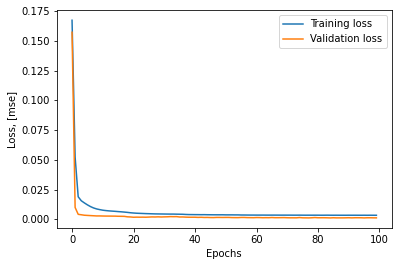

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

In [15]:
X_pred = model.predict(X_train)

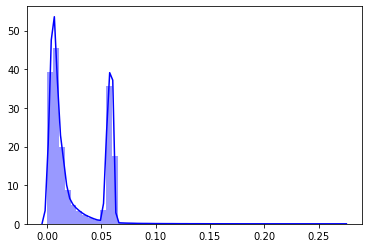

In [16]:
import seaborn as sns

scored = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
g = sns.distplot(scored, bins = 50, kde= True, color = 'blue');
#g.set(xlim=(0.10,0.1), ylim=(0, 1))
plt.show()

In [17]:
model.evaluate(X_test,X_test)

48448/48448 [==============================] - 1s 23us/step


0.001230501337575206

In [18]:
X_test_pred = model.predict(X_test)

In [19]:
X_test_pred = X_test_pred.reshape(X_test_pred.shape[0],X_test_pred.shape[2])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[2])

In [20]:
TH = 0.07
scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_test_pred-X_test), axis = 1)
scored['Threshold'] = TH
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.sample(100)

,Loss_mae,Threshold,Anomaly
8084,0.042241,0.07,False
40264,0.008014,0.07,False
25080,0.005961,0.07,False
15887,0.037049,0.07,False
24006,0.038925,0.07,False
...,...,...,...
6578,0.040925,0.07,False
40831,0.011670,0.07,False
7662,0.039640,0.07,False
35204,0.009110,0.07,False


In [21]:
X_pred_train = model.predict(np.array(X_train))

In [22]:
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0],X_pred_train.shape[2])
X_train = X_train.reshape(X_train.shape[0],X_train.shape[2])

In [23]:
X_pred_train = pd.DataFrame(X_pred_train)
scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = TH
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [24]:
scored_train['Loss_mae'].mean()

0.025656915444507163

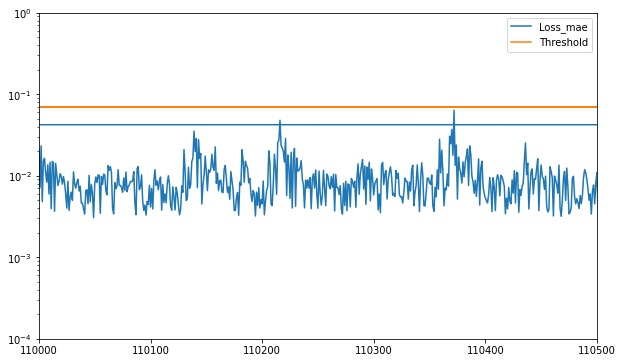

In [25]:
scored.plot(logy=True,  figsize = (10,6), xlim = [110000,110500], ylim = [1e-4,1e-0])

In [26]:
scored_train

,Loss_mae,Threshold,Anomaly
0,0.038901,0.07,False
1,0.043282,0.07,False
2,0.041519,0.07,False
3,0.043993,0.07,False
4,0.040900,0.07,False
...,...,...,...
193787,0.078893,0.07,True
193788,0.014372,0.07,False
193789,0.053049,0.07,False
193790,0.006027,0.07,False


In [27]:
anomalies = scored_train[scored_train['Anomaly'] == True]
print(anomalies)
print(anomalies.shape)

        Loss_mae  Threshold  Anomaly
98245   0.079512       0.07     True
98397   0.071317       0.07     True
101142  0.075789       0.07     True
101981  0.070973       0.07     True
102362  0.071773       0.07     True
...          ...        ...      ...
187611  0.076153       0.07     True
189670  0.079714       0.07     True
190280  0.071075       0.07     True
192342  0.078688       0.07     True
193787  0.078893       0.07     True

[63 rows x 3 columns]
(63, 3)


In [28]:
NB_anomalies = anomalies[anomalies.index <= 96896]
print(NB_anomalies)
print(NB_anomalies.shape)

Empty DataFrame
Columns: [Loss_mae, Threshold, Anomaly]
Index: []
(0, 3)


In [29]:
IR7_anomalies = anomalies[anomalies.index > 96896]
print(IR7_anomalies)
print(IR7_anomalies.shape)

        Loss_mae  Threshold  Anomaly
98245   0.079512       0.07     True
98397   0.071317       0.07     True
101142  0.075789       0.07     True
101981  0.070973       0.07     True
102362  0.071773       0.07     True
...          ...        ...      ...
187611  0.076153       0.07     True
189670  0.079714       0.07     True
190280  0.071075       0.07     True
192342  0.078688       0.07     True
193787  0.078893       0.07     True

[63 rows x 3 columns]
(63, 3)


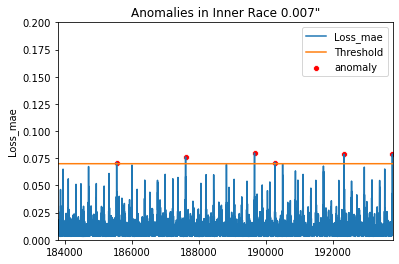

In [30]:
plt.plot(scored_train.index, scored_train.Loss_mae, label='Loss_mae')
plt.plot(scored_train.index, scored_train.Threshold, label='Threshold')
g = sns.scatterplot(x=anomalies.index , y=anomalies.Loss_mae, label='anomaly', color='red')
g.set(xlim = (len(scored_train.index)-10000, len(scored_train.index)), ylim = (0, 0.2))
plt.title('Anomalies in Inner Race 0.007"')
plt.legend();